# Problem statement:
We want to build a surrogate model with a Convolutional Recurrent NN architecture to learn and predict the time-evolution of a bi-dimensional phase-field.
It will be supplied as an image (npy array) with $n \times n$ pixels. The convolutional architecture helps us capturing the local correlations between nearby correlated pixels, while the recurrent architecture helps us better learn the temporal evolution.

## Step 2

What if we try to still supply just one step $x_t$ (no need to supply more since the problem is a markov chain of step 1), but we go one step back more in information: 
- step 0: we can just predict $x_{t+1}$ (not smart)
- step 1: we can predict $dx = x_{t+1} - x_{t}$ (that's what we just previously did)
- step 2: we can predict $\varepsilon = x_{t+1} - 2x_t + x_{t-1}$ (that's what we are going to do now)


We import some useful libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We use the same parameters and function to compute the time-evolution

In [2]:
alpha = 0.05 # scaling factor
dt = 1 # integration time-step
T = 100 # number of time steps
x0 = 1 # initial condition
t = np.arange(T+1) # time
x = np.zeros(T+1) # scalar to evolve

In [3]:
# function defining the time-evolution
def propagate(x, alpha, dt):
    x_i = x*(1 - np.cos((x-1)*np.pi)*alpha*dt) + 0.005*dt
    
    return x_i

Let's check a bunch of starting conditions

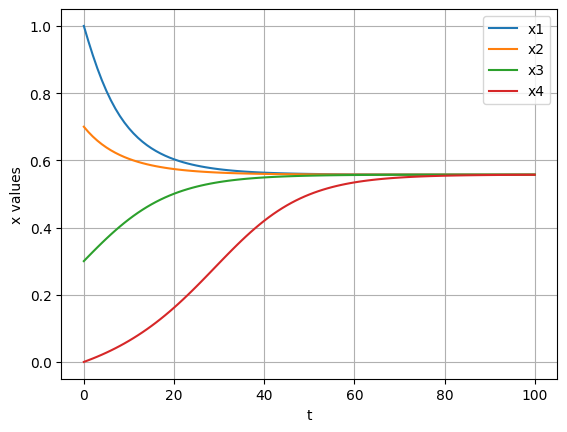

In [4]:
# checking the behaviour formultiple starting conditions
x1 = np.zeros(T+1)
x2 = np.zeros(T+1)
x3 = np.zeros(T+1)
x4 = np.zeros(T+1)
x1[0] = 1.0
x2[0] = 0.7
x3[0] = 0.3
x4[0] = 0.0

for i in range(1, T+1):
    x1[i] = propagate(x1[i-1], alpha, dt)
    x2[i] = propagate(x2[i-1], alpha, dt)
    x3[i] = propagate(x3[i-1], alpha, dt)
    x4[i] = propagate(x4[i-1], alpha, dt)

plt.plot(t, x1, label='x1')
plt.plot(t, x2, label='x2')
plt.plot(t, x3, label='x3')
plt.plot(t, x4, label='x4')
plt.xlabel('t')
plt.ylabel('x values')
plt.legend()
plt.grid()
#plt.yscale('log')

Ok, let's try to learn such dynamics.

First of all we create a dataset of conditions, and we want to predict the next step.

In [5]:
x_tm1 = np.random.rand(300) # starting point
x_t = propagate(x_tm1, alpha, dt)  
x_tp1 = propagate(x_t, alpha, dt) 

x_tilde = 2*x_t - x_tm1
epsilon = x_tp1 - x_tilde

Text(0, 0.5, '$\\varepsilon$')

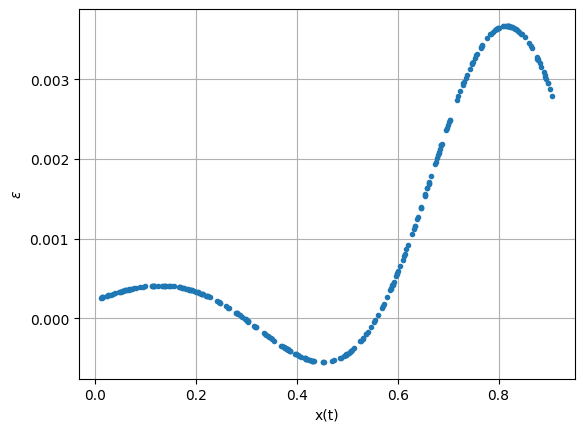

In [6]:
plt.plot(x_tilde, epsilon, '.')
plt.grid()
plt.xlabel('x(t)')
plt.ylabel(r'$\varepsilon$')

Let's import the libraries to build such NN model

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

In [8]:
def generate_dataset(N, alpha=alpha, dt=dt):
    x_tm1 = np.random.rand(300) # starting point
    x_t = propagate(x_tm1, alpha, dt)  
    x_tp1 = propagate(x_t, alpha, dt) # real target

    x_tilde = 2*x_t - x_tm1 # auxiliary input
    epsilon = x_tp1 - x_tilde   # auxiliary target

    np.save('x_t.npy', x_t)
    np.save('x_tm1.npy', x_tm1)
    np.save('x_tp1.npy', x_tp1)

    np.save('x_tilde.npy', x_tilde)
    np.save('epsilon.npy', epsilon)

    # =========================
    # 1. Load dataset
    # =========================
    X = np.load("x_t.npy")     # shape: (N, d)
    y = np.load("epsilon.npy")    # shape: (N,) or (N, 1)

    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Fit scaler on y
    y_scaler = StandardScaler()
    y_scaled = y_scaler.fit_transform(y)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

    # Wrap into dataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # =========================
    # 2. Train-validation split
    # =========================
    val_ratio = 0.2
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=32)

    return train_dataset, val_dataset, train_loader, val_loader, y_scaler

    

In [9]:
def new_model(in_dim, out_dim, act_fun, my_nn, lr, epochs, train_loader, val_loader):
    class Net(nn.Module):
        def __init__(self, in_dim, out_dim):  
            super(Net, self).__init__()
            if len(my_nn) == 1:
                if act_fun == 'ReLU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ReLU(),
                        nn.Linear(my_nn[0], out_dim),
                    )
            
                if act_fun == 'ELU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ELU(),
                        nn.Linear(my_nn[0], out_dim),
                    )

                if act_fun == 'Tanh':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.Tanh(),
                        nn.Linear(my_nn[0], out_dim),
                    )

            if len(my_nn) == 2:
                if act_fun == 'ReLU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ReLU(),
                        nn.Linear(my_nn[0], my_nn[-1]),
                        nn.ReLU(),
                        nn.Linear(my_nn[-1], out_dim),
                    )
            
                if act_fun == 'ELU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ELU(),
                        nn.Linear(my_nn[0], my_nn[-1]),
                        nn.ELU(),
                        nn.Linear(my_nn[-1], out_dim),
                    )

                if act_fun == 'Tanh':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.Tanh(),
                        nn.Linear(my_nn[0], my_nn[-1]),
                        nn.Tanh(),
                        nn.Linear(my_nn[-1], out_dim),
                    )
        
        def forward(self, x):
            return self.layers(x)

    # Infer input/output dimensions
    #input_dim = X.shape[1] if X.ndim > 1 else 1
    #output_dim = 1 if y.ndim == 1 else y.shape[1]

    model = Net(in_dim, out_dim)

    criterion = nn.MSELoss()  
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_tra_saved = np.empty(epochs)
    loss_val_saved = np.empty(epochs)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view_as(preds))  # reshape if needed
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb.view_as(preds))
                val_loss += loss.item()
    
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}")
    
        loss_tra_saved[epoch] = train_loss / 0.8
        loss_val_saved[epoch] = val_loss / 0.2

    torch.save(model.state_dict(), "model.pth")

    saved_model = Net(1, 1)
    saved_model.load_state_dict(torch.load("model.pth"))
    saved_model.eval()

    return loss_tra_saved, loss_val_saved, saved_model

In [10]:
def plot_loss(epochs, loss_tra_saved, loss_val_saved):
    plt.plot(range(epochs), loss_tra_saved, label='training')
    plt.plot(range(epochs), loss_val_saved, label='validation')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()

In [11]:
def next_step_pred(train_dataset, val_dataset, saved_model, X_test):
    X_train = train_dataset[:][0].numpy()
    y_train = train_dataset[:][1].numpy()

    X_val = val_dataset[:][0].numpy()
    y_val = val_dataset[:][1].numpy()

    with torch.no_grad():
        y_pred_test = saved_model(torch.tensor(X_test, dtype=torch.float32)).numpy()

    plt.figure(figsize=(8,6))

    plt.scatter(X_train, y_train, color="blue", label="Train data")
    plt.scatter(X_val, y_val, color="green", label="Validation data")
    plt.scatter(X_test, y_pred_test, color="red", marker=".", label="Predictions")

    plt.legend()
    plt.xlabel("Input")
    plt.ylabel("Target")
    plt.title("Model Fit on Training and Validation Data")
    plt.grid()

In [12]:
def predict_dynamics(alpha, dt, y_scaler, saved_model):
    t = np.arange(T+1)
    x1_true = np.zeros(T+1)
    x2_true = np.zeros(T+1)
    x3_true = np.zeros(T+1)
    x4_true = np.zeros(T+1)
    x1_true[0] = 1.0
    x2_true[0] = 0.7
    x3_true[0] = 0.3
    x4_true[0] = 0.0

    x1_pred = np.zeros(T+1)
    x2_pred = np.zeros(T+1)
    x3_pred = np.zeros(T+1)
    x4_pred = np.zeros(T+1)
    x1_pred[0] = 1.0
    x2_pred[0] = 0.7
    x3_pred[0] = 0.3
    x4_pred[0] = 0.0

    x1_true[1] = propagate(x1_true[0], alpha, dt)
    x2_true[1] = propagate(x2_true[0], alpha, dt)
    x3_true[1] = propagate(x3_true[0], alpha, dt)
    x4_true[1] = propagate(x4_true[0], alpha, dt)


    for i in range(2, T+1):
        x1_true[i] = propagate(x1_true[i-1], alpha, dt)
        x2_true[i] = propagate(x2_true[i-1], alpha, dt)
        x3_true[i] = propagate(x3_true[i-1], alpha, dt)
        x4_true[i] = propagate(x4_true[i-1], alpha, dt)

    x1_pred[1] = propagate(x1_pred[0], alpha, dt)
    x2_pred[1] = propagate(x2_pred[0], alpha, dt)
    x3_pred[1] = propagate(x3_pred[0], alpha, dt)
    x4_pred[1] = propagate(x4_pred[0], alpha, dt)

    with torch.no_grad():
        for i in range(2, T+1):
            x1_pred[i] = 2*x1_pred[i-1] - x1_pred[i-2] + y_scaler.inverse_transform(saved_model(torch.tensor(x1_pred[i-1].reshape(-1,1), dtype=torch.float32)).numpy()).flatten()[0]
            x2_pred[i] = 2*x2_pred[i-1] - x2_pred[i-2] + y_scaler.inverse_transform(saved_model(torch.tensor(x2_pred[i-1].reshape(-1,1), dtype=torch.float32)).numpy()).flatten()[0]
            x3_pred[i] = 2*x3_pred[i-1] - x3_pred[i-2] + y_scaler.inverse_transform(saved_model(torch.tensor(x3_pred[i-1].reshape(-1,1), dtype=torch.float32)).numpy()).flatten()[0]
            x4_pred[i] = 2*x4_pred[i-1] - x4_pred[i-2] + y_scaler.inverse_transform(saved_model(torch.tensor(x4_pred[i-1].reshape(-1,1), dtype=torch.float32)).numpy()).flatten()[0]

    plt.plot(t, x1_true,'--', label='x1_true', linewidth=3)
    plt.plot(t, x2_true,'--', label='x2_true', linewidth=3)
    plt.plot(t, x3_true,'--', label='x3_true', linewidth=3)
    plt.plot(t, x4_true,'--', label='x4_true', linewidth=3)
    first_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    plt.plot(t, x1_pred, '-', label="x1_pred", color=first_color)
    second_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    plt.plot(t, x2_pred, '-', label="x2_pred", color=second_color)
    third_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
    plt.plot(t, x3_pred, '-', label="x3_pred", color=third_color)
    fourth_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
    plt.plot(t, x4_pred, '-', label="x4_pred", color=fourth_color)

    plt.xlabel('t')
    plt.ylabel('x values')
    plt.legend()
    plt.grid()

What works:
- dataset size: 500
- train val split: 0.20
- layers/neurons: [3]
- activation functions: Tanh
- learning rate: 0.001
- epochs: 3000

In [13]:
N = 500
in_dim = 1
out_dim = 1
act_fun = 'Tanh'
my_nn = [3]
lr = 0.001
epochs = 3000

In [ ]:
train_dataset, val_dataset, train_loader, val_loader, y_scaler = generate_dataset(N=N, alpha=alpha, dt=dt)
loss_tra_saved, loss_val_saved, saved_model = new_model(in_dim=in_dim, out_dim=out_dim, 
                                                        act_fun=act_fun, my_nn=my_nn, lr=lr, epochs=epochs, 
                                                        train_loader=train_loader, val_loader=val_loader)

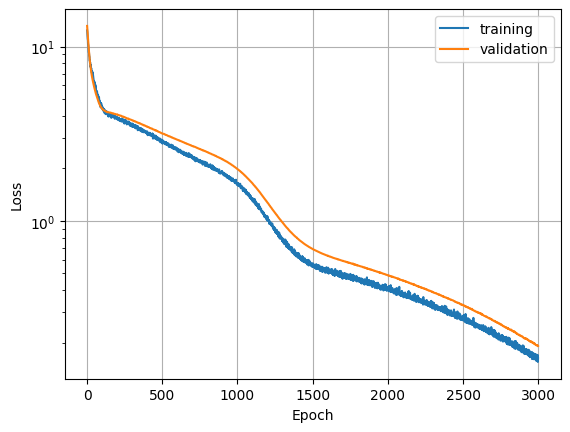

In [15]:
plot_loss(epochs, loss_tra_saved, loss_val_saved)

In [16]:
x_tm1_test = np.linspace(0, 1, 500) # starting point
x_t_test = propagate(x_tm1_test, alpha, dt)  
x_tp1_test = propagate(x_t_test, alpha, dt)  

x_tilde_test = 2*x_t_test - x_tm1_test
epsilon_test = x_tp1_test - x_tilde_test

X_test = x_tilde_test.reshape(-1, 1)
y_test = epsilon_test.reshape(-1, 1)

# Fit scaler on y
y_test_scaled = y_scaler.transform(y_test)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

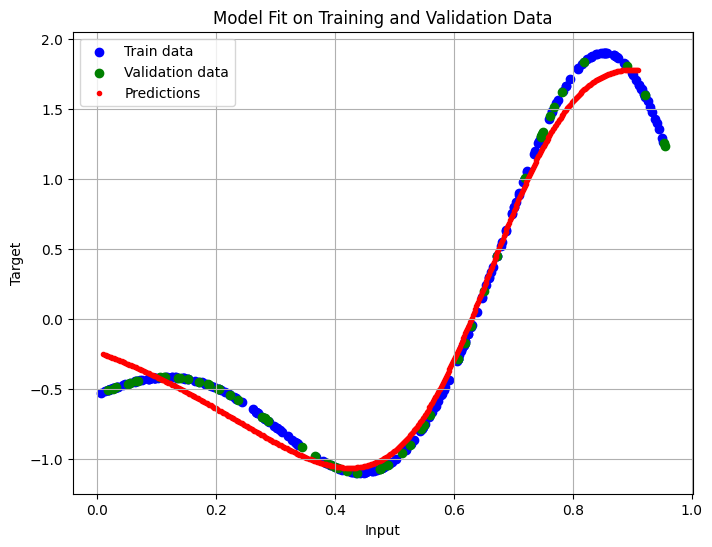

In [17]:
next_step_pred(train_dataset=train_dataset, val_dataset=val_dataset, saved_model=saved_model, X_test=X_test)

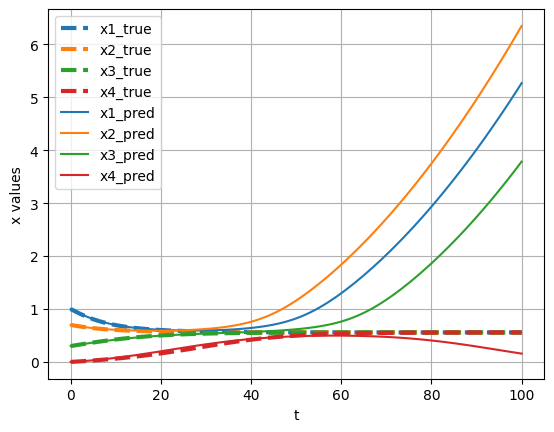

In [18]:
predict_dynamics(alpha=alpha, dt=dt, y_scaler=y_scaler, saved_model=saved_model)

Not good with the same initialization... 

It needs more epochs and also the function is a bit more complex, so maybe a bunch more neurons are needed

In [19]:
N = 500
in_dim = 1
out_dim = 1
act_fun = 'Tanh'
my_nn = [5]
lr = 0.001
epochs = 10000

In [ ]:
train_dataset, val_dataset, train_loader, val_loader, y_scaler = generate_dataset(N=N, alpha=alpha, dt=dt)
loss_tra_saved, loss_val_saved, saved_model = new_model(in_dim=in_dim, out_dim=out_dim, 
                                                        act_fun=act_fun, my_nn=my_nn, lr=lr, epochs=epochs, 
                                                        train_loader=train_loader, val_loader=val_loader)

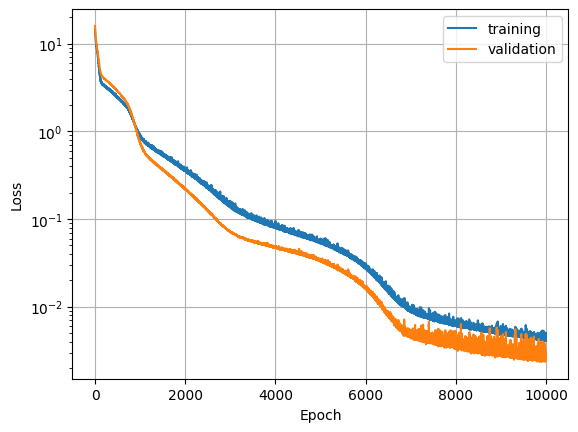

In [21]:
plot_loss(epochs, loss_tra_saved, loss_val_saved)

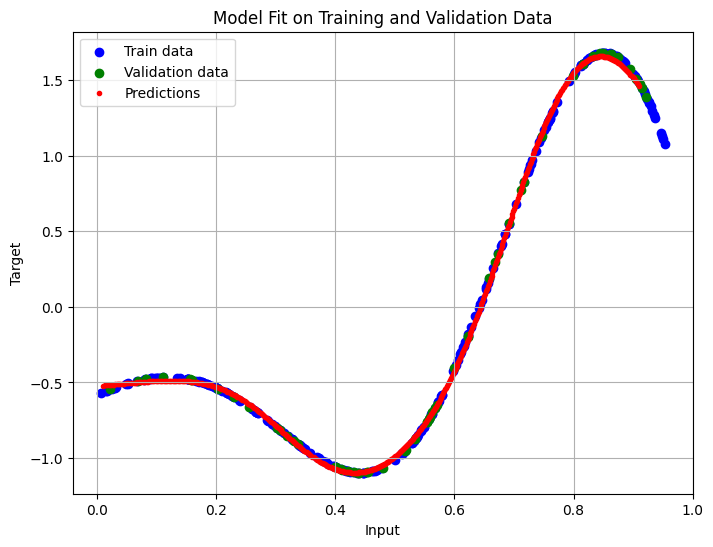

In [22]:
next_step_pred(train_dataset=train_dataset, val_dataset=val_dataset, saved_model=saved_model, X_test=X_test)

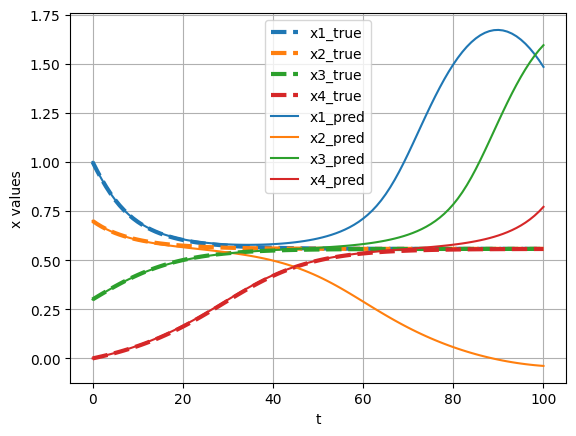

In [23]:
predict_dynamics(alpha=alpha, dt=dt, y_scaler=y_scaler, saved_model=saved_model)

It doesn't fit too bad, but still we get these big errors in dynamics... Quite unexpcted.

We can try fit even better!


In [24]:
N = 500
in_dim = 1
out_dim = 1
act_fun = 'Tanh'
my_nn = [16, 8]
lr = 0.001
epochs = 10000

In [ ]:
train_dataset, val_dataset, train_loader, val_loader, y_scaler = generate_dataset(N=N, alpha=alpha, dt=dt)
loss_tra_saved, loss_val_saved, saved_model = new_model(in_dim=in_dim, out_dim=out_dim, 
                                                        act_fun=act_fun, my_nn=my_nn, lr=lr, epochs=epochs, 
                                                        train_loader=train_loader, val_loader=val_loader)

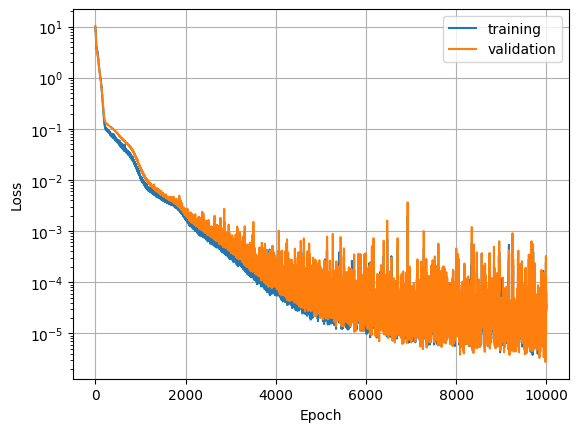

In [26]:
plot_loss(epochs, loss_tra_saved, loss_val_saved)

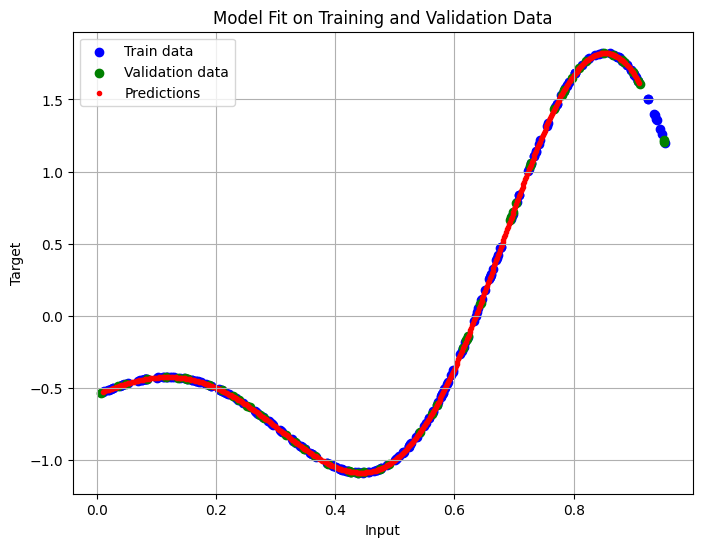

In [27]:
next_step_pred(train_dataset=train_dataset, val_dataset=val_dataset, saved_model=saved_model, X_test=X_test)

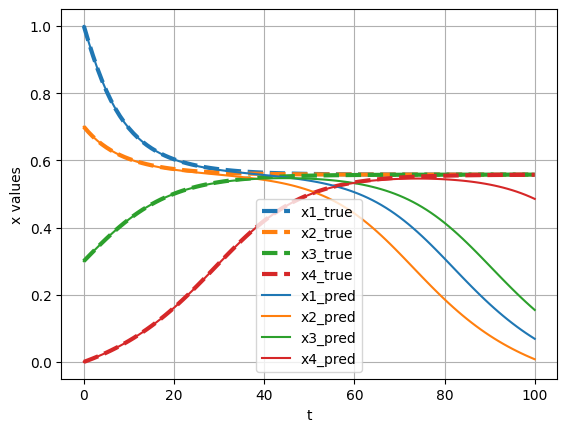

In [28]:
predict_dynamics(alpha=alpha, dt=dt, y_scaler=y_scaler, saved_model=saved_model)

2nd order is not stable